# CS933 Image & Video Analysis coursework 2023-2024, Part 1
> ID: 5556162, Name: Tien Yu Lin

## Module imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

from lib.public import (
    db,
    find_single_components_in,
    find_centroid_from,
    show_images_in_row,
    central_line_of,
    rotate_image,
    crop_img_to_fixed_size,
    vertical_color_distribution_of,
    show_vertical_rgb_analysis_of,
)

## Read origin images

In [2]:
origin_r1 = cv2.imread(f"{db.resistor_dir}/RESISTORS-1.png")
origin_r2 = cv2.imread(f"{db.resistor_dir}/RESISTORS-2.png")
origin_r3 = cv2.imread(f"{db.resistor_dir}/RESISTORS-3.png")

## Resistor 1 and 2 (Synthetic Images)

### Find single components of resistor

In [3]:
r1_resistors, b_r1_resistors = find_single_components_in(origin_r1)
r2_resistors, b_r2_resistors = find_single_components_in(origin_r2)

### crop resistor image to left only body part

In [4]:
r1_bodies = [resistor[320:580, :] for resistor in r1_resistors]
b_r1_bodies = [b_resistor[320:580, :] for b_resistor in b_r1_resistors]

In [5]:
# Crop the resistor 2 images to a fixed size.
# It should base on the central point of the image.

crop_size_x = 160
crop_size_y = 220

r2_bodies = [
    crop_img_to_fixed_size(resistor, crop_size_x, crop_size_y)
    for resistor in r2_resistors
]

b_r2_bodies = [
    crop_img_to_fixed_size(resistor, crop_size_x, crop_size_y)
    for resistor in b_r2_resistors
]

### Rotate the image according to the central line

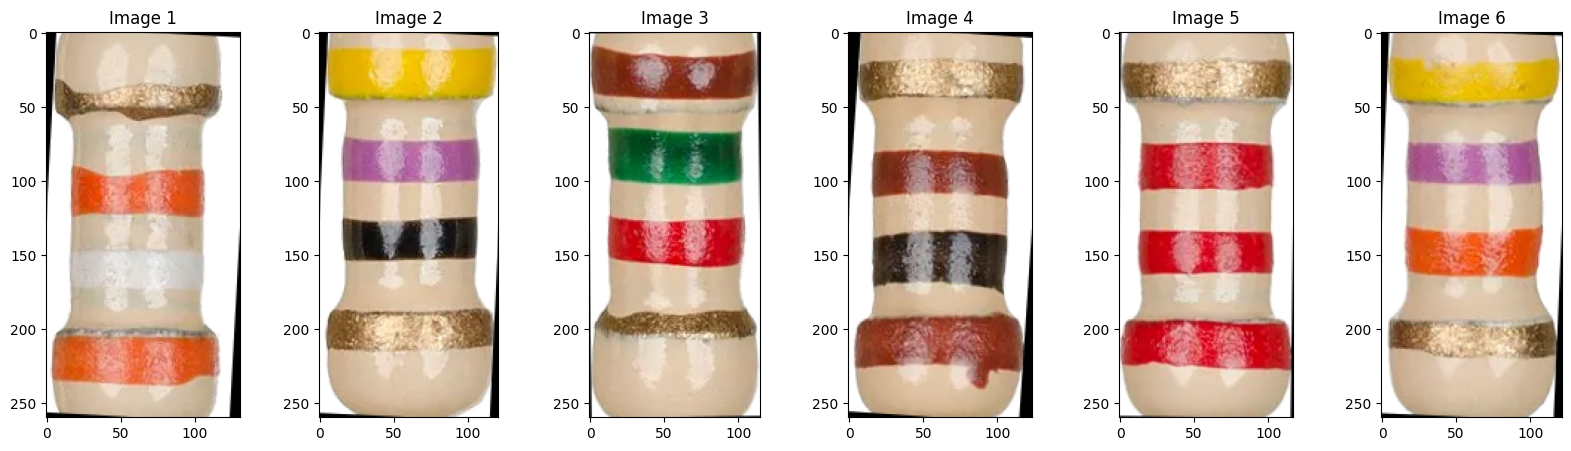

In [6]:
r1_body_rotated = []

for i, resistor in enumerate(r1_bodies):
    central_line = central_line_of(b_r1_bodies[i])
    centroid = find_centroid_from(b_r1_bodies[i])
    rotated = rotate_image(resistor, central_line, centroid)
    r1_body_rotated.append(rotated)

show_images_in_row(r1_body_rotated)

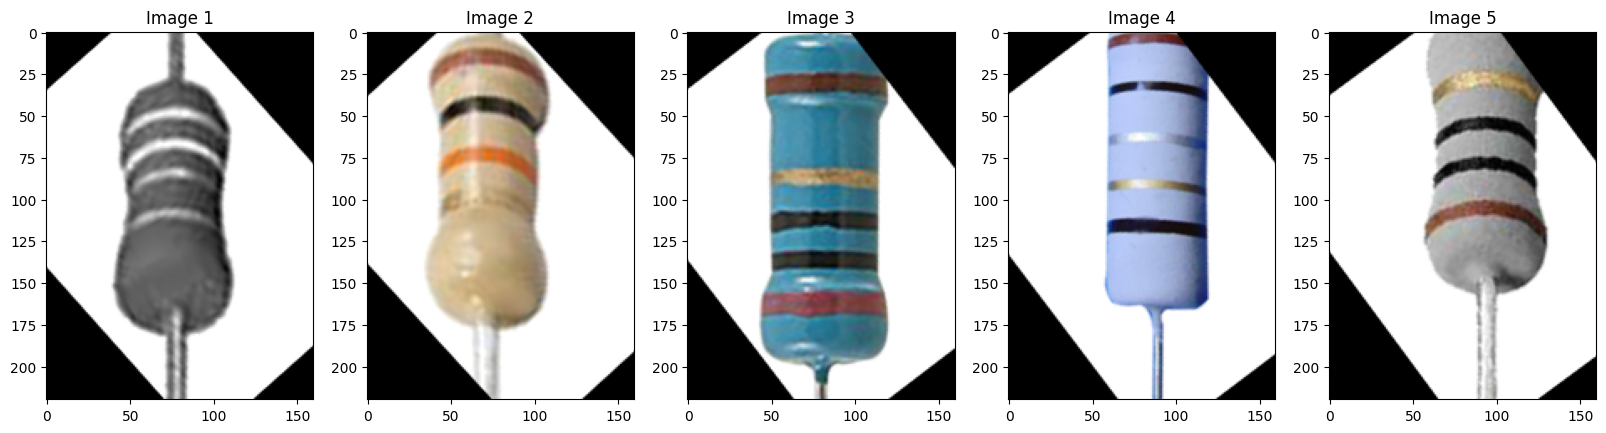

In [7]:
r2_body_rotated = []

for i, resistor in enumerate(r2_bodies):
    central_line = central_line_of(b_r2_bodies[i])
    centroid = find_centroid_from(b_r2_bodies[i])
    rotated = rotate_image(resistor, central_line, centroid)
    r2_body_rotated.append(rotated)

show_images_in_row(r2_body_rotated)

### Crop images to only contain the resistor body

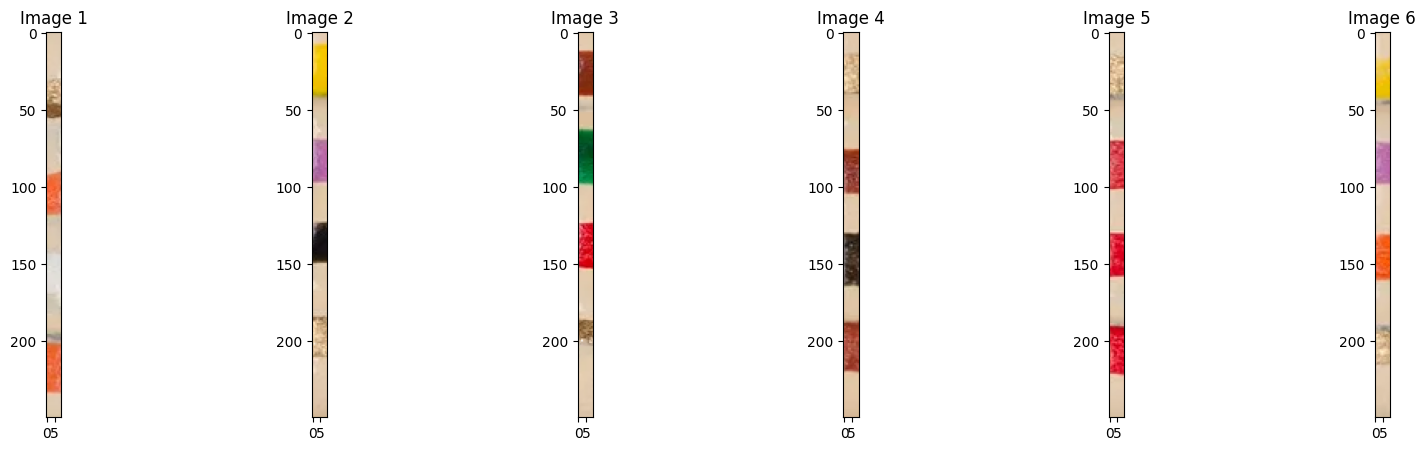

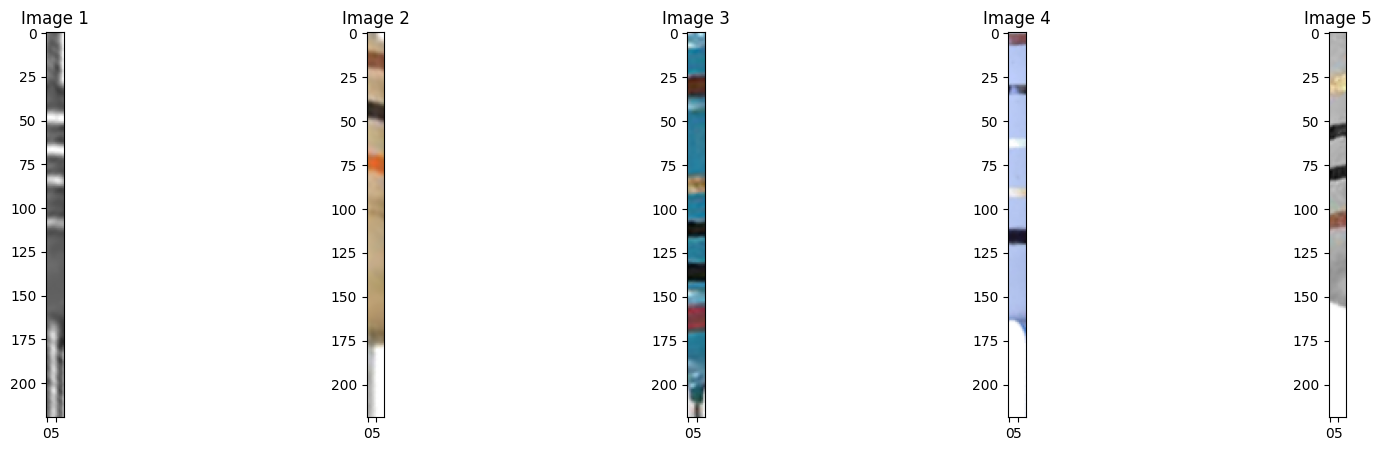

In [8]:
crop_size_x = 10

crop_r1_size_y = 250

r1_band_areas = [
    crop_img_to_fixed_size(resistor, crop_size_x, crop_r1_size_y)
    for resistor in r1_body_rotated
]

crop_r2_size_y = 220

r2_band_areas = [
    crop_img_to_fixed_size(resistor, crop_size_x, crop_r2_size_y)
    for resistor in r2_body_rotated
]

show_images_in_row(r1_band_areas)
show_images_in_row(r2_band_areas)

### Use image pyramid to find the bands

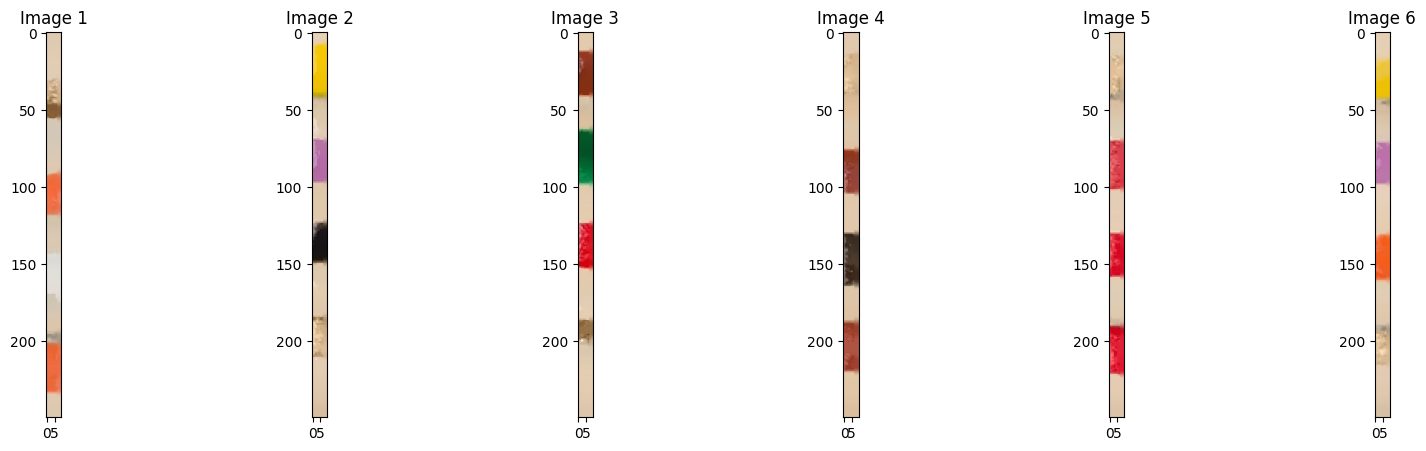

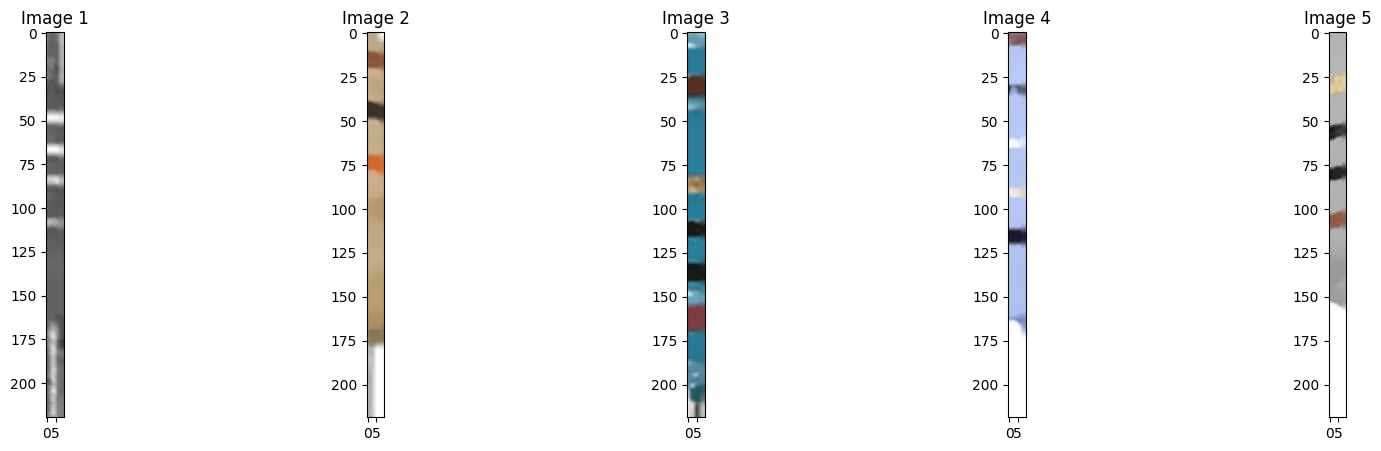

In [9]:
r1_band_areas_sub_sampled = [
    cv2.pyrMeanShiftFiltering(resistor, 5, 20)
    for resistor in r1_band_areas
]

r2_band_areas_sub_sampled = [
    cv2.pyrMeanShiftFiltering(resistor, 5, 20)
    for resistor in r2_band_areas
]

show_images_in_row(r1_band_areas_sub_sampled)
show_images_in_row(r2_band_areas_sub_sampled)

### Analyse the color distribution of the band areas from top to bottom

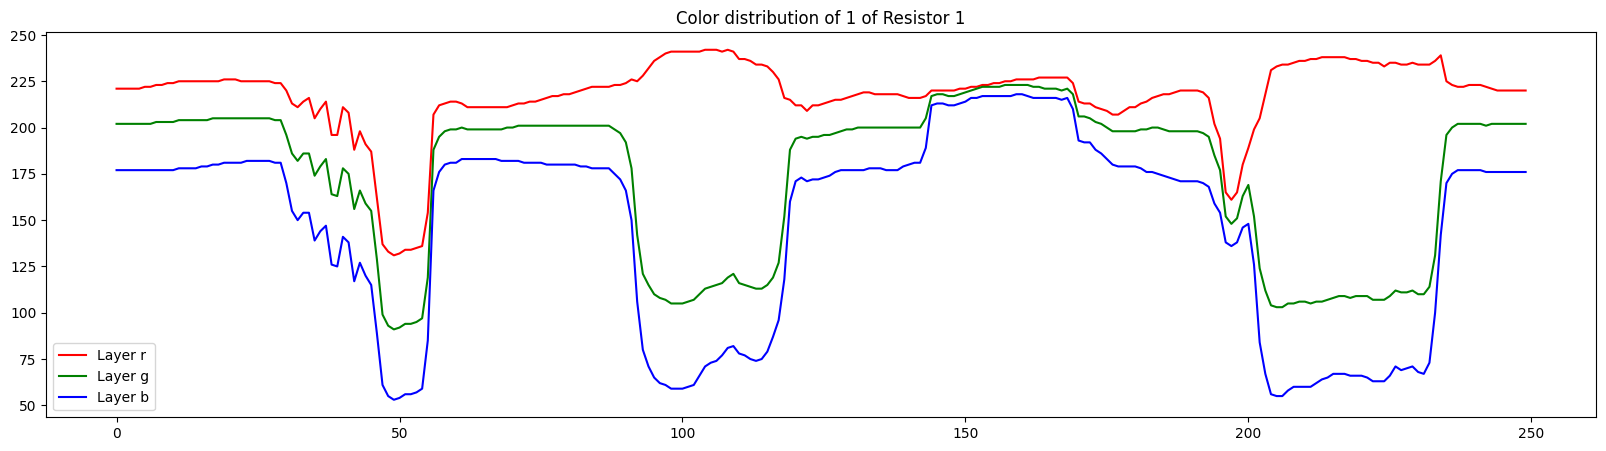

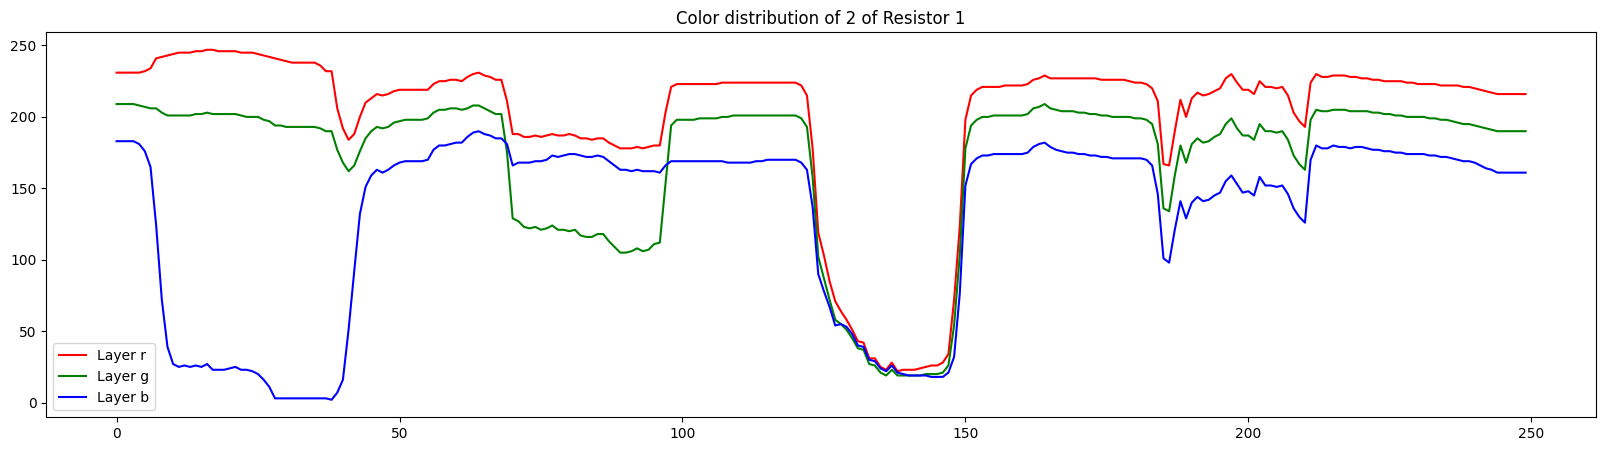

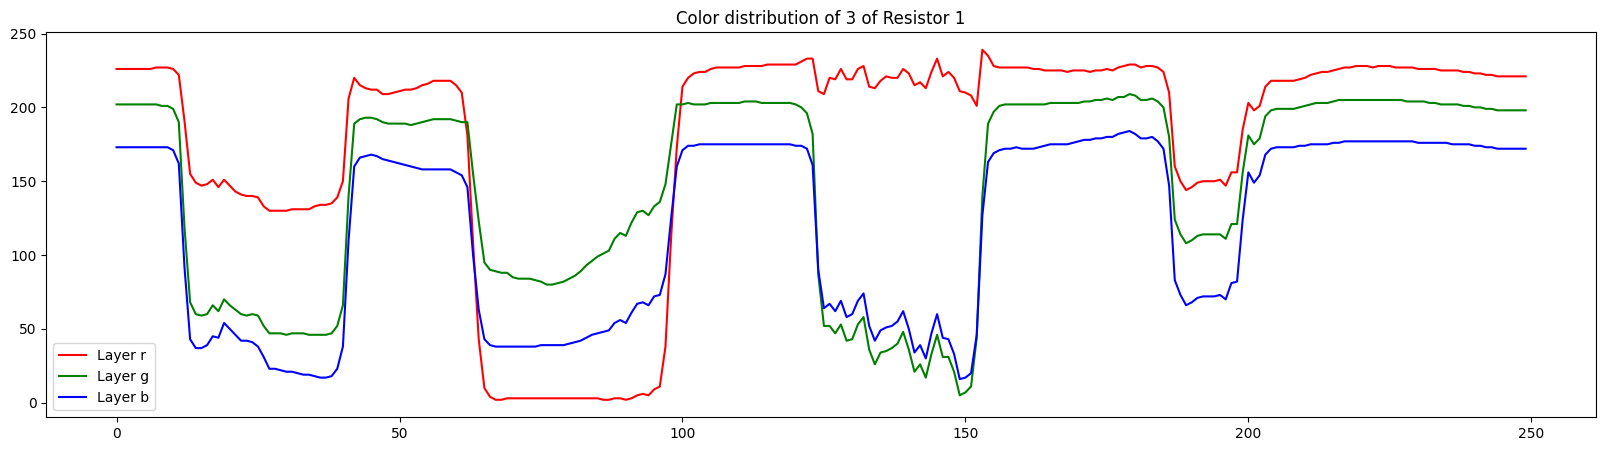

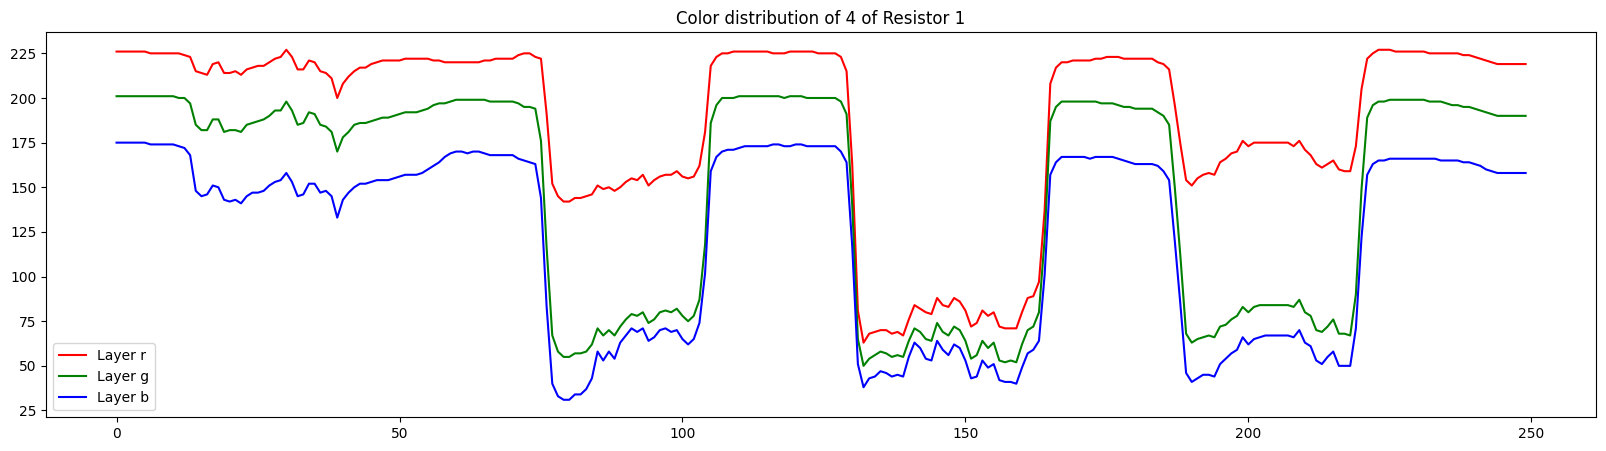

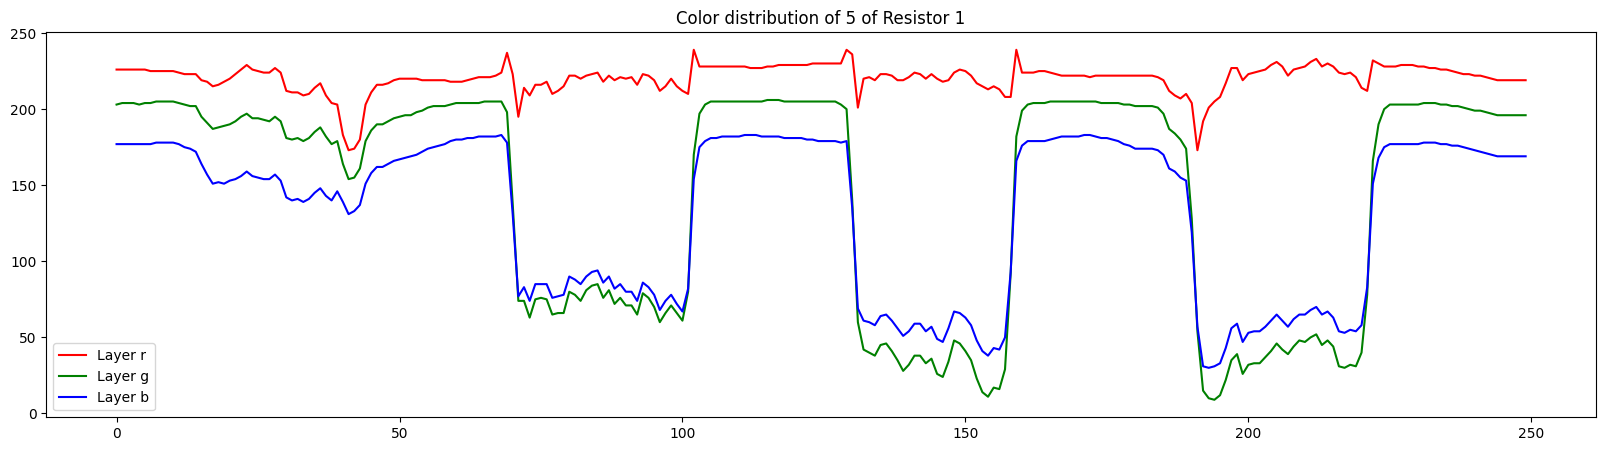

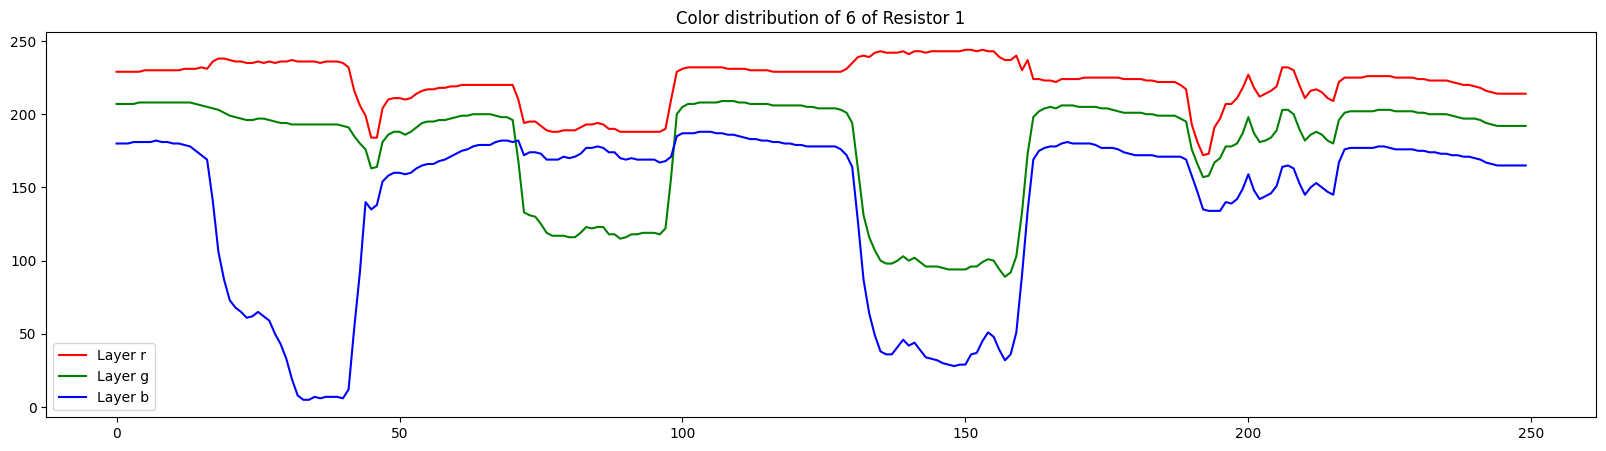

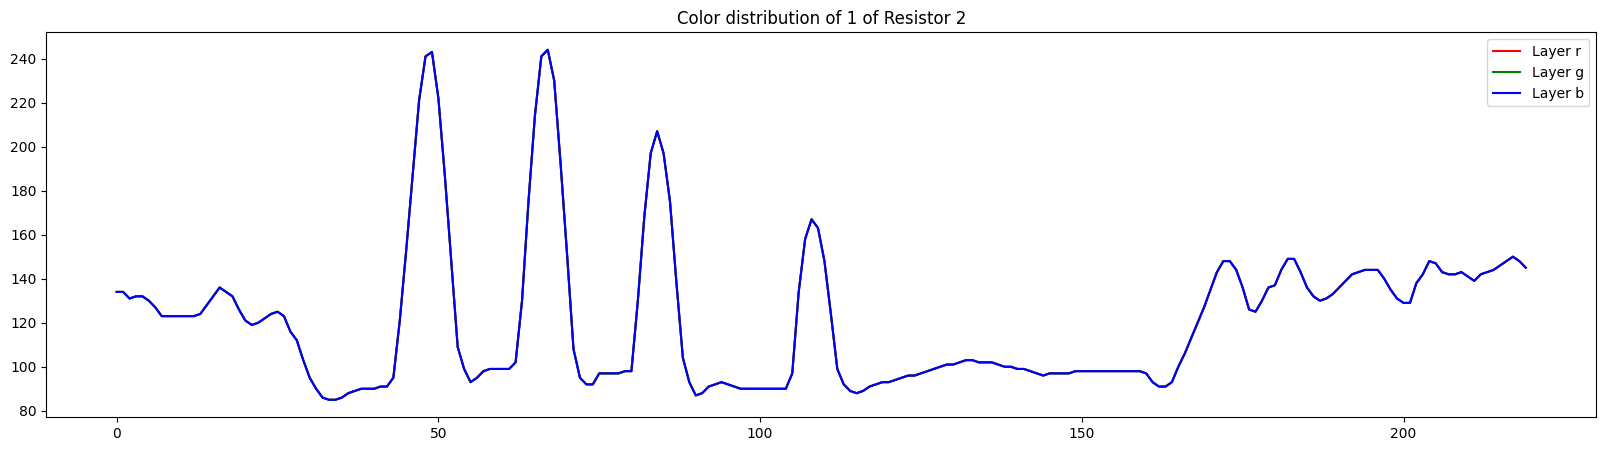

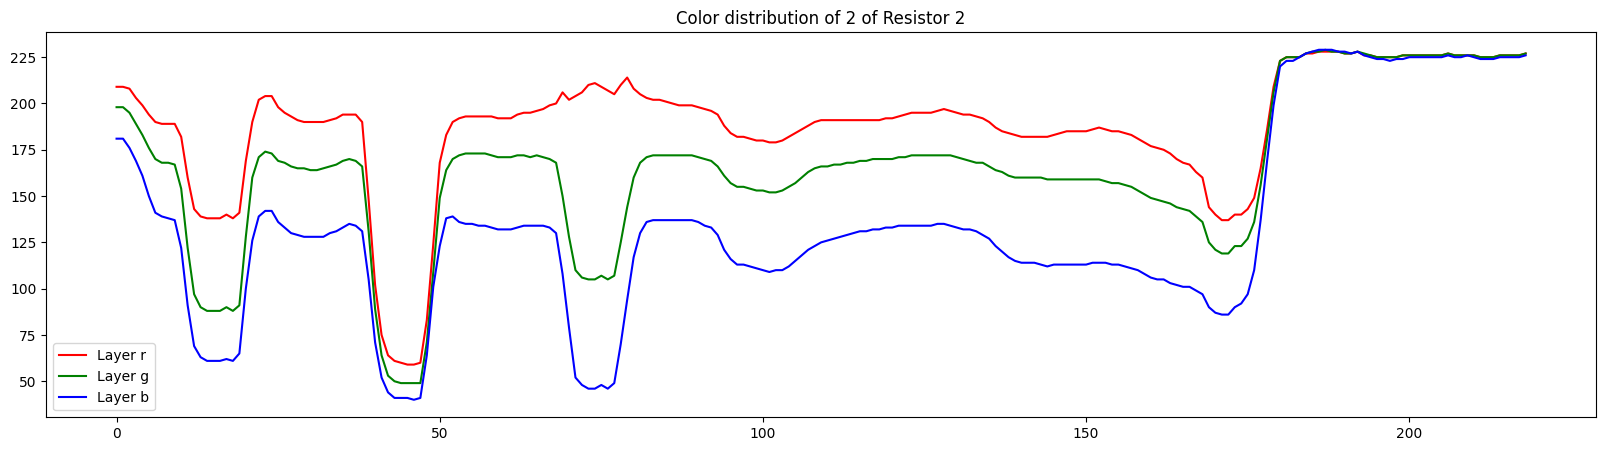

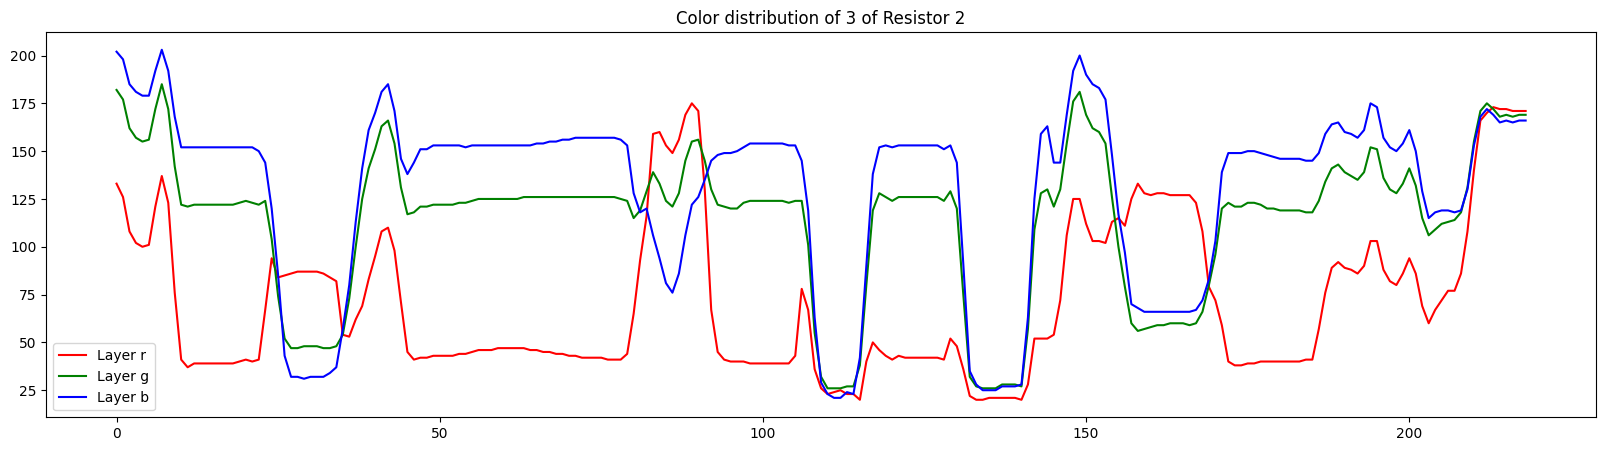

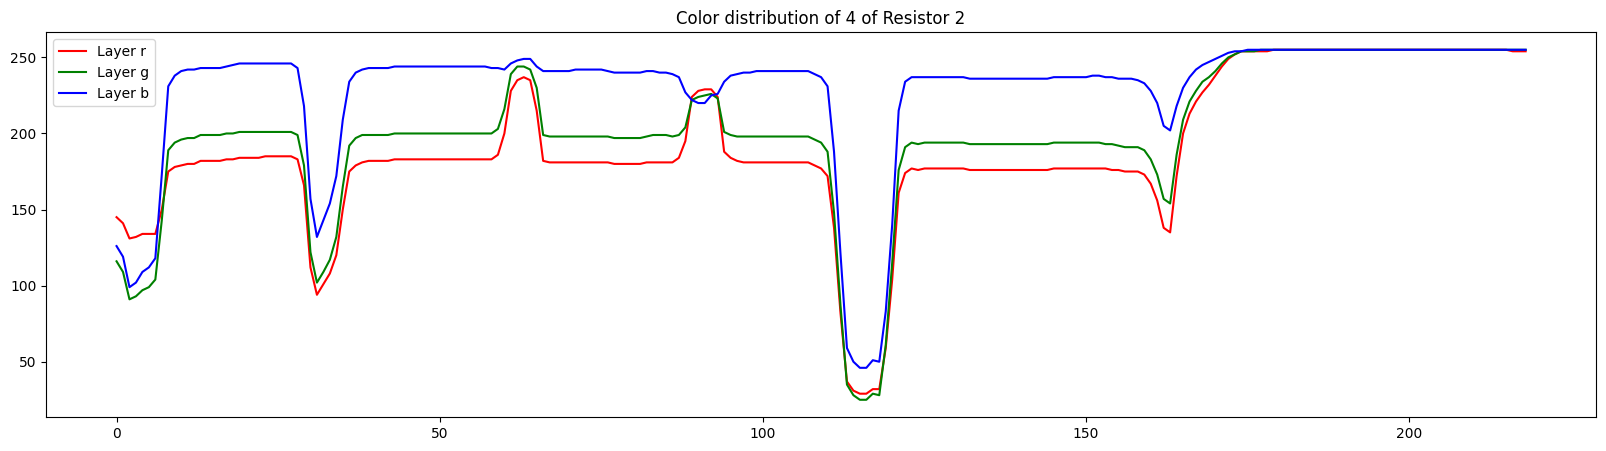

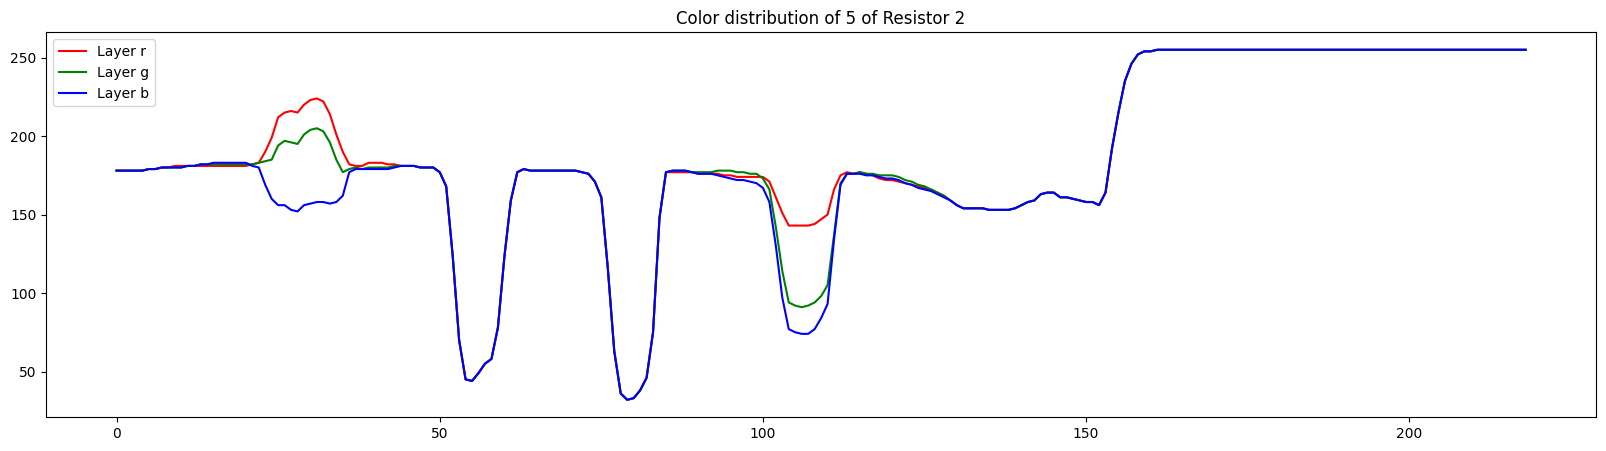

In [10]:
for n, resistor in enumerate(r1_band_areas_sub_sampled):
    analysis_result = vertical_color_distribution_of(resistor)
    show_vertical_rgb_analysis_of(analysis_result, label=f"{n + 1} of Resistor 1")

for n, resistor in enumerate(r2_band_areas_sub_sampled):
    analysis_result = vertical_color_distribution_of(resistor)
    show_vertical_rgb_analysis_of(analysis_result, label=f"{n + 1} of Resistor 2")

## Resistor 3 (Real World Image)

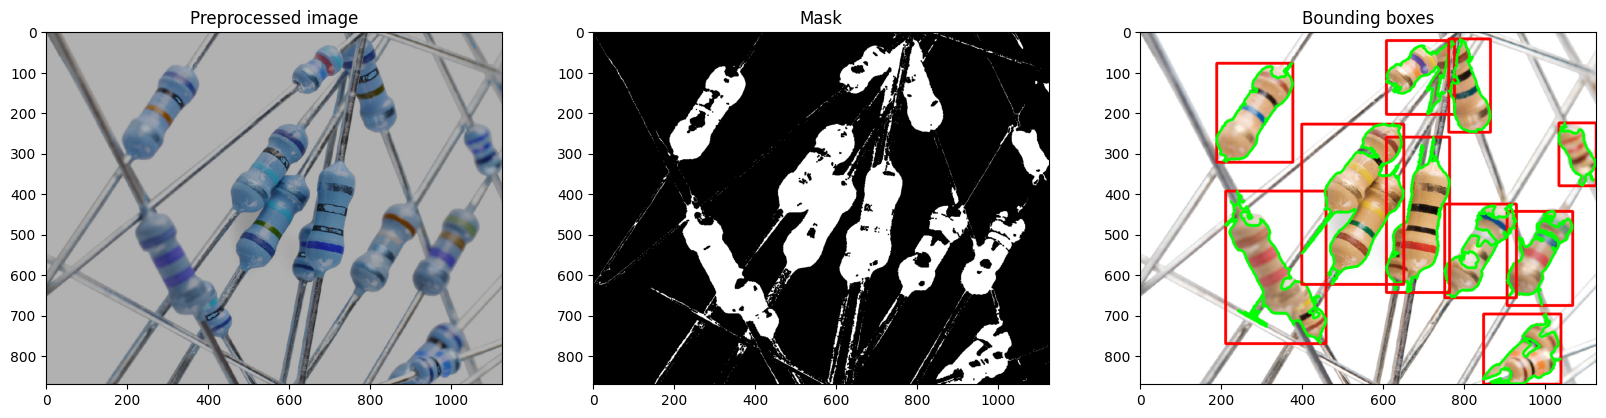

In [11]:
# Note that using opencv to read the image will result in BGR format
r3 = origin_r3.copy()

beige_bgr = (117, 174, 220)

# Create a 1x3 subplot with labels
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

"""
Step 1, Preprocessing
Change some specific colors so that makes the image easier to be masked.
"""

# Lighten areas which nearly black, not just black
# This is because some bands on the beige of a resistor are black,
# However, some parts of the resistor conduct lines are also black.
# If we don't lighten the black color, we may not able to change them into beige's color by just using the threshold in HSV color space.
is_near_black = (r3[:, :, 0] < 40) & (r3[:, :, 1] < 40) & (r3[:, :, 2] < 40)
r3[is_near_black] = beige_bgr

# Changing the color of area which nearly gray.
# Since the background of the whole image is white,
# and some of the bands on the beige of a resistor are also white,
# we need to accurately change the color of the bands on the beige of a resistor to beige's color,
# otherwise those gray bands will become empty gap,
# after we change all the bands' color to beige.
is_near_gray = (
        (r3[:, :, 0] > 150)
        & (r3[:, :, 2] < 190)
        & (r3[:, :, 1] > 170)
        & (r3[:, :, 1] < 185)
        & (r3[:, :, 2] > 180)
        & (r3[:, :, 0] < 190)
)
r3[is_near_gray] = beige_bgr

# Decrease the brightness of the image for better color conversion
r3 = cv2.convertScaleAbs(r3, alpha=-0.7, beta=1.2)

# Show current r3 image in the first subplot with label
axs[0].imshow(r3)
axs[0].set_title("Preprocessed image")

"""
Step 2, Edge detection
Try to find edges of each resistor for helping us to separate resistors.
"""

# For finding edges, we need to use grayscale image.
r3_gray = cv2.cvtColor(r3, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise for edge detection
blurred = cv2.GaussianBlur(r3_gray, (19, 19), 0)

# Find edges in the image using the Canny edge detector
edges = cv2.Canny(blurred, 19, 50)

# Dilate the edges to make them thicker
dilated_edges = cv2.dilate(edges, np.ones((1, 1), np.uint8), iterations=2)

# Put edges onto the original image, and make edges white
r3[dilated_edges > 0] = (255, 255, 255)

"""
Step 3, Masking
Convert the color of bands on the beige of a resistor to beige's color.
"""

# Use HSV color space to avoid the influence of brightness, e.g. reflection.
hsv_r3 = cv2.cvtColor(r3, cv2.COLOR_BGR2HSV)

# Assuming beige and silver (the body and the ends of the resistors) are not to be masked,
# we create a mask for all other colors which would be the color bands
mask_lower = np.array([0, 50, 50])
mask_upper = np.array([179, 255, 255])

y_mask = cv2.inRange(hsv_r3, mask_lower, mask_upper)
bands_mask = cv2.bitwise_not(y_mask)

# Now, convert all colored bands to beige color (approximately)
r3[np.where(bands_mask == 0)] = beige_bgr

# Define range for the beige color of resistor bodies in HSV
beige_lower = np.array([15, 40, 100])
beige_upper = np.array([50, 255, 255])

# Convert the image (with band masks) to HSV color space
hsv_r3 = cv2.cvtColor(r3, cv2.COLOR_BGR2HSV)

# Threshold the HSV image to get only beige colors
mask = cv2.inRange(hsv_r3, beige_lower, beige_upper)

# Use morphological operations to close gaps in the mask
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# Show the mask in the second subplot
axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Mask")

"""
Step 4, Bounding boxes
Find bounding boxes of each resistor.
"""

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area (this depends on the image resolution and size of resistors)
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 850]

# Draw bounding boxes around detected resistor bodies
r3_for_display = origin_r3.copy()
min_contour_area = 6400  # minimum contour area to be considered
for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(r3_for_display, (x, y), (x + w, y + h), (0, 0, 255), 6)
    if cv2.contourArea(cnt) > min_contour_area:
        cv2.drawContours(r3_for_display, [cnt], 0, (0, 255, 0), 6)

# Show the bounding boxes in the third subplot
axs[2].imshow(cv2.cvtColor(r3_for_display, cv2.COLOR_BGR2RGB))
axs[2].set_title("Bounding boxes")

plt.show()

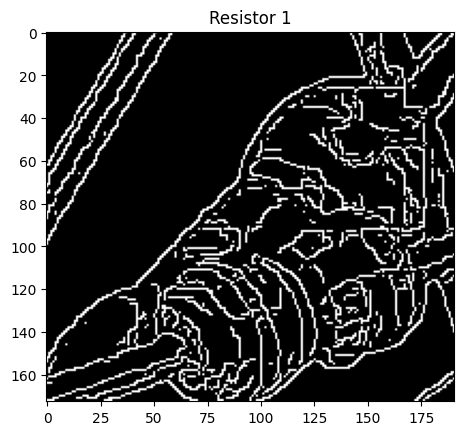

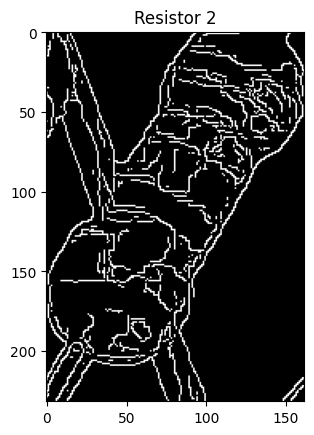

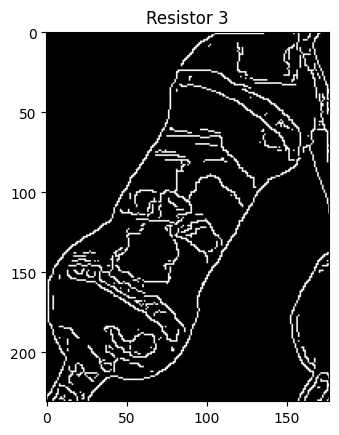

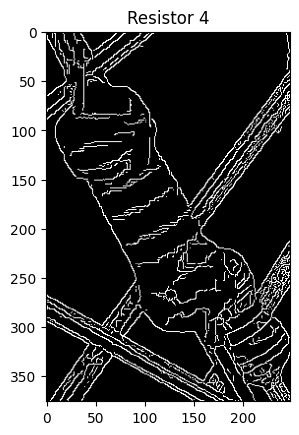

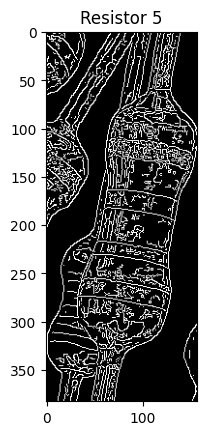

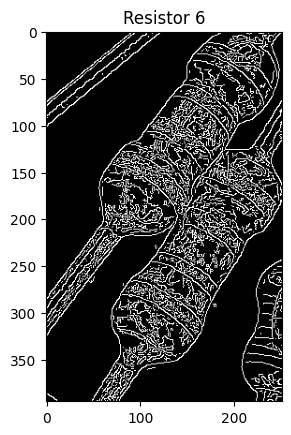

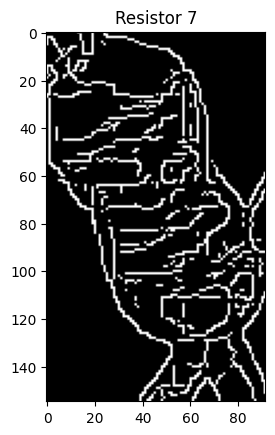

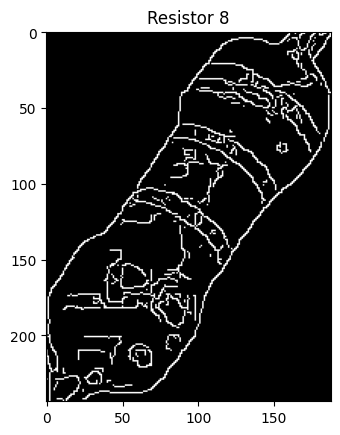

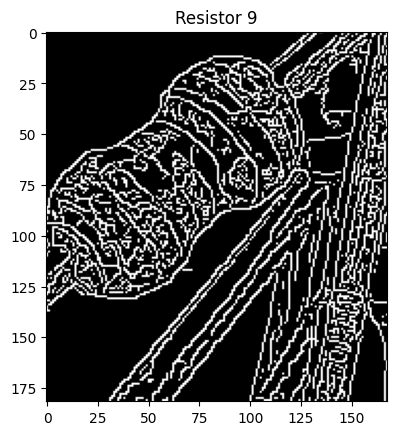

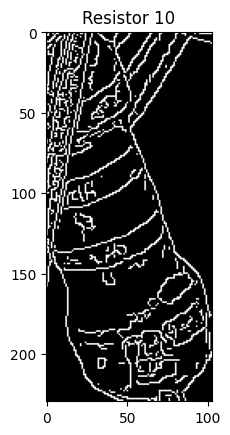

In [12]:
# Convert mask to binary image
mask[mask > 0] = 1
labeled_r3_set = measure.label(mask, background=0)
labels_of_r3_resistors = np.unique(labeled_r3_set)

# Show each resistor in a separate image
for i, cnt in enumerate(filtered_contours):
    x, y, w, h = cv2.boundingRect(cnt)
    resistor = origin_r3[y: y + h, x: x + w]
    edges = cv2.Canny(resistor, 19, 50, apertureSize=3, L2gradient=True)

    plt.imshow(edges, cmap="gray")
    plt.title(f"Resistor {i + 1}")
    plt.show()